In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2023-12-22 08:10:32,751: Default instance: ibm-q/open/main


In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA, NELDER_MEAD
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from itertools import permutations #per brutal approches TSP

In [4]:
#draw a graph by coloring the nodes 
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

### TSP 

In [5]:
counts=[]
params=[]
values=[]
mddict=[]
def store_intermediate_result(count, parameters, value, step):
    counts.append(count)
    params.append(parameters)
    values.append(value)
    mddict.append(step)
  #  nonso.append(nnso)

In [6]:
### Proviamoo a definire un grafo con 4 vertici

In [7]:
n = 4  # Number of nodes in graph
G_4 = nx.Graph()
G_4.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1), (0, 2, 1), (0, 3, 3), (1, 2, 3), (1, 3, 1), (2,3,1)]
# tuple is (i,j,weight) where (i,j) is the edge
G_4.add_weighted_edges_from(elist)

colors = ["r" for node in G_4.nodes()]
pos = nx.spring_layout(G_4)

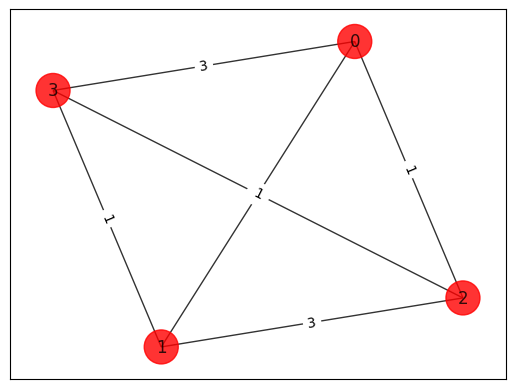

In [8]:
draw_graph(G_4, colors, pos)

In [9]:
tsp4 = Tsp(G_4)

In [10]:
adj_matrix1 = nx.to_numpy_array(tsp4.graph)

In [11]:
qp_tsp4 = tsp4.to_quadratic_program()
#print(qp_tsp4.prettyprint())

In [12]:
qp2qubo_tsp4 = QuadraticProgramToQubo()
qubo_tsp4 = qp2qubo_tsp4.convert(qp_tsp4)
#print(str(qubo.prettyprint()))
qubitOp_tsp4, offset = qubo_tsp4.to_ising()
#print("Offset:", offset)
#print("Ising Hamiltonian:")
#print(str(qubitOp_tsp1.to_matrix().real))
#print(str(qubitOp_tsp4))

In [13]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result_tsp_1 = ee.compute_minimum_eigenvalue(qubitOp_tsp4)

print("energy:", result_tsp_1.eigenvalue.real)
print("tsp objective:", result_tsp_1.eigenvalue.real + offset)
x_tsp = tsp4.sample_most_likely(result_tsp_1.eigenstate)
print("feasible:", qubo_tsp4.is_feasible(x_tsp))
z_tsp = tsp4.interpret(x_tsp)
print("solution:", z_tsp)
print("solution objective:", tsp4.tsp_value(z_tsp, adj_matrix1))

energy: -1312.0
tsp objective: 4.0
feasible: True
solution: [0, 1, 3, 2]
solution objective: 4.0


In [14]:
algorithm_globals.random_seed = 123
seed = 10598

In [15]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


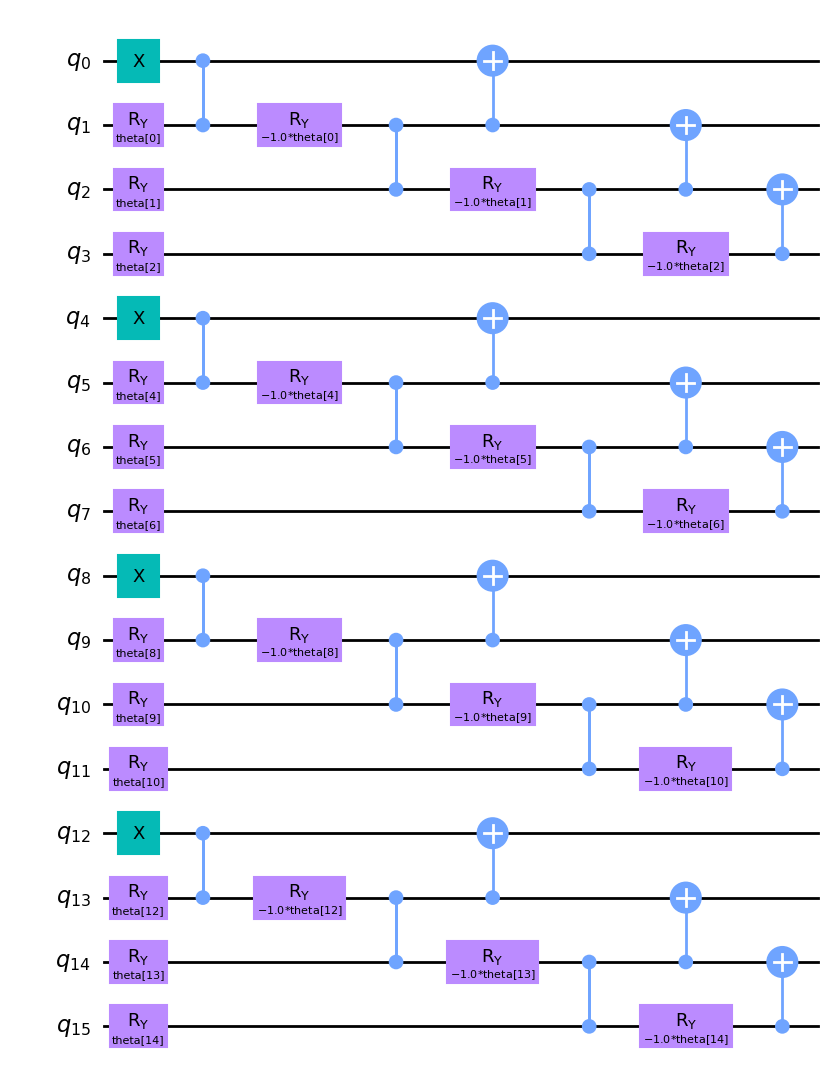

In [16]:
# create the Ansatz
theta = ParameterVector('theta', qubitOp_tsp4.num_qubits)
qc2 = QuantumCircuit(qubitOp_tsp4.num_qubits)
for i in range (0,qubitOp_tsp4.num_qubits, n):
    qc2.x(i)
    for j in range(i+1,i+n,1):
        qc2.ry(theta[j-1], j)
        qc2.cz(j-1,j)
        qc2.ry(-theta[j-1], j)
    for j in range(i+1,i+n,1):
        qc2.cx(j,j-1)
qc2.draw('mpl')

energy: -1266.0786647172897
time: 7.243179798126221
feasible: True
solution: [2, 3, 1, 0]
solution objective: 4.0


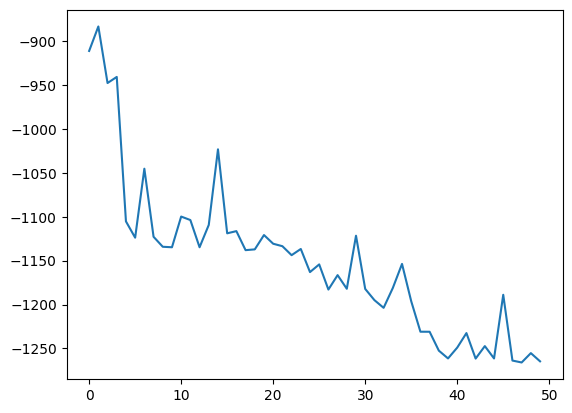

In [94]:
counts=[]
params=[]
values=[]
mddict=[]
#init=np.zeros(qubitOp_tsp4.num_qubits-n)
optimizer = COBYLA(maxiter=50)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE 
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if qp_tsp4.is_feasible(x_clb)== True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

1
energy: -1311.9214611707162
time: 25.326491117477417
feasible: True
solution objective: 4.0
2
energy: -1311.9372329906907
time: 26.3923978805542
feasible: True
solution objective: 4.0
3
energy: -1307.9698806084684
time: 26.89042377471924
feasible: True
solution objective: 8.0
4
energy: -1307.801899340634
time: 25.148992776870728
feasible: True
solution objective: 8.0
5
energy: -1307.9554724220052
time: 25.30701231956482
feasible: True
solution objective: 8.0
6
energy: -1307.9296971686172
time: 27.324691772460938
feasible: True
solution objective: 8.0
7
energy: -1307.668192581351
time: 26.41382646560669
feasible: True
solution objective: 8.0
8
energy: -1311.8469688942355
time: 25.969911575317383
feasible: True
solution objective: 4.0
9
energy: -1311.9944393645396
time: 26.185182809829712
feasible: True
solution objective: 4.0
27.324691772460938
25.148992776870728
26.106547832489014
-1307.668192581351
-1311.9944393645396
-1309.6694716156953


4

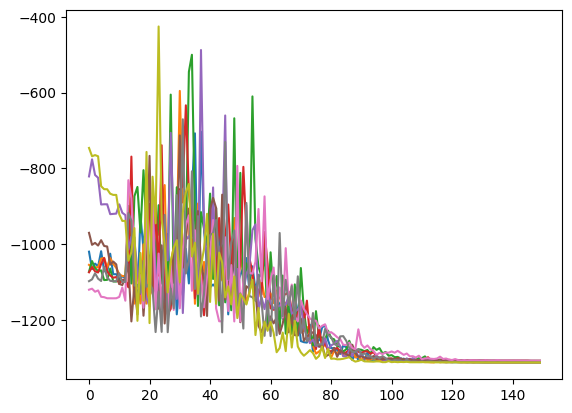

In [98]:
time=[]
energy=[]
solution=[]
for i in range (1,10,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    print(i)
    optimizer = COBYLA(maxiter=150, rhobeg=50)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    print("energy:", result_clb.eigenvalue.real)
    print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1
energy: -1307.8924198445186
time: 20.05263066291809
feasible: True
solution objective: 8.0
2
energy: -1307.8781902599208
time: 20.93773889541626
feasible: True
solution objective: 8.0
3
energy: -1311.959556599858
time: 20.285203218460083
feasible: True
solution objective: 4.0
4
energy: -1311.8932986025127
time: 19.653573036193848
feasible: True
solution objective: 4.0
5
energy: -1311.9551829349498
time: 20.904202699661255
feasible: True
solution objective: 4.0
6
energy: -1307.9528390918551
time: 21.034948348999023
feasible: True
solution objective: 8.0
7
energy: -1311.9097845110866
time: 21.116575002670288
feasible: True
solution objective: 4.0
8
energy: -1307.9665747094032
time: 19.91494607925415
feasible: True
solution objective: 8.0
9
energy: -1307.7522510902693
time: 20.851255655288696
feasible: True
solution objective: 8.0
21.116575002670288
19.653573036193848
20.527897066540188
-1307.7522510902693
-1311.959556599858
-1309.6844552938194


4

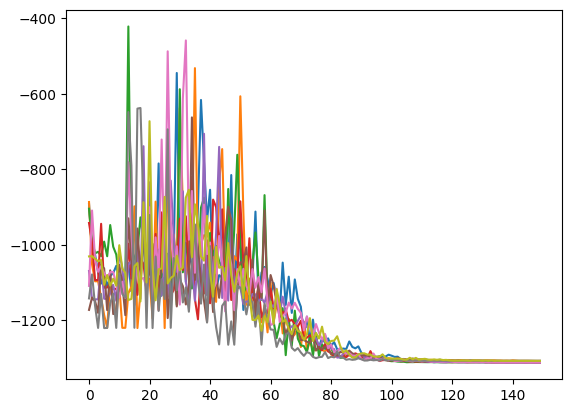

In [100]:
time=[]
energy=[]
solution=[]
for i in range (1,10,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    print(i)
    optimizer = COBYLA(maxiter=150, rhobeg=80)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    print("energy:", result_clb.eigenvalue.real)
    print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1
energy: -1307.9424799006383
time: 20.939810037612915
feasible: True
solution objective: 8.0
2
energy: -1307.8579671787722
time: 20.407554626464844
feasible: True
solution objective: 8.0
3
energy: -1307.6217528675338
time: 20.299224138259888
feasible: True
solution objective: 8.0
4
energy: -1311.953847020946
time: 20.779174089431763
feasible: True
solution objective: 4.0
5
energy: -1307.6692131100797
time: 20.099763870239258
feasible: True
solution objective: 8.0
6
energy: -1307.9161629511705
time: 21.304668426513672
feasible: True
solution objective: 8.0
7
energy: -1307.6116224495865
time: 20.595726013183594
feasible: True
solution objective: 8.0
8
energy: -1307.9659202279552
time: 20.648610591888428
feasible: True
solution objective: 8.0
9
energy: -1307.9105195914437
time: 21.35018277168274
feasible: True
solution objective: 8.0
21.35018277168274
20.099763870239258
20.713857173919678
-1307.6116224495865
-1311.953847020946
-1308.272165033125


1

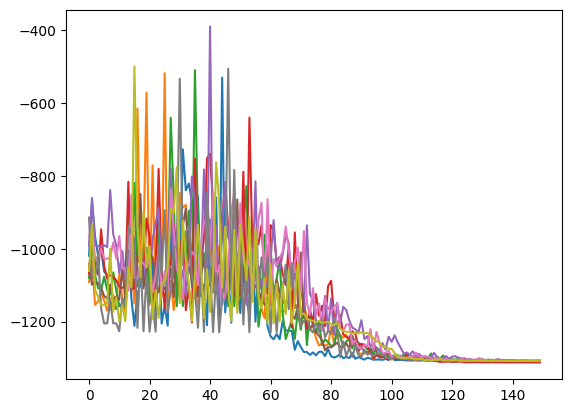

In [101]:
time=[]
energy=[]
solution=[]
for i in range (1,10,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    print(i)
    optimizer = COBYLA(maxiter=150, rhobeg=150)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    print("energy:", result_clb.eigenvalue.real)
    print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1
energy: -1307.9818083228656
time: 20.79956579208374
feasible: True
solution objective: 8.0
2
energy: -1311.79350249415
time: 20.518847227096558
feasible: True
solution objective: 4.0
3
energy: -1311.6237432092244
time: 20.76613450050354
feasible: True
solution objective: 4.0
4
energy: -1307.1446785200612
time: 22.081645488739014
feasible: True
solution objective: 8.0
5
energy: -1307.6386746757275
time: 22.041985750198364
feasible: True
solution objective: 8.0
6
energy: -1311.8714469114393
time: 21.039020538330078
feasible: True
solution objective: 4.0
7
energy: -1307.9636930467782
time: 19.99729061126709
feasible: True
solution objective: 8.0
8
energy: -1311.6698565016425
time: 20.590141773223877
feasible: True
solution objective: 4.0
9
energy: -1307.8011089648414
time: 20.753276348114014
feasible: True
solution objective: 8.0
22.081645488739014
19.99729061126709
20.95421200328403
-1307.1446785200612
-1311.8714469114393
-1309.4987236274144


4

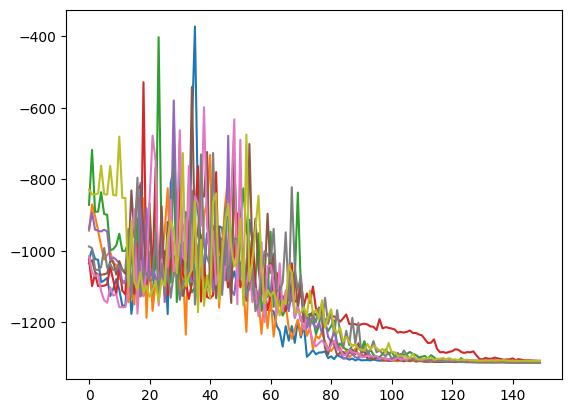

In [103]:
time=[]
energy=[]
solution=[]
for i in range (1,10,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    print(i)
    optimizer = COBYLA(maxiter=150, rhobeg=100)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    print("energy:", result_clb.eigenvalue.real)
    print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

1
energy: -1300.862408844213
time: 7.2440056800842285
feasible: True
solution objective: 8.0
2
energy: -1296.8556862192654
time: 6.969247341156006
feasible: True
solution objective: 4.0
3
energy: -1285.9483112526013
time: 6.917569160461426
feasible: True
solution objective: 8.0
4
energy: -1283.5517914916607
time: 6.92440128326416
feasible: True
solution objective: 8.0
5
energy: -1301.408726100373
time: 6.979439735412598
feasible: True
solution objective: 4.0
6
energy: -1297.6571487603223
time: 7.067400693893433
feasible: True
solution objective: 8.0
7
energy: -1301.103289129352
time: 7.237103462219238
feasible: True
solution objective: 8.0
8
energy: -1298.8014370664882
time: 6.825366020202637
feasible: True
solution objective: 8.0
9
energy: -1287.0519297959838
time: 6.699975490570068
feasible: True
solution objective: 4.0
10
energy: -1284.7760091654316
time: 6.847174167633057
feasible: True
solution objective: 8.0
11
energy: -1285.8666251206482
time: 6.628570795059204
feasible: True
so

30

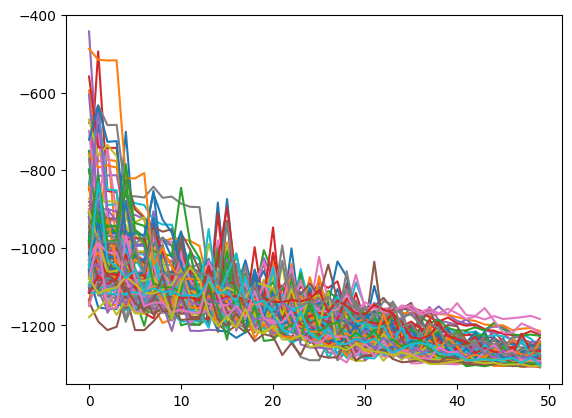

In [95]:
# construct SamplingVQE with callback
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    print(i)
    optimizer = COBYLA(maxiter=50)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    print("energy:", result_clb.eigenvalue.real)
    print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

16.402127027511597
12.73941445350647
13.913350439071655
-1305.9478199379378
-1311.9625429305115
-1309.1597767048102


36

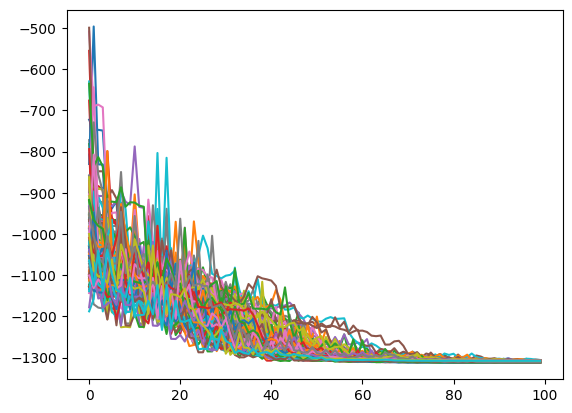

In [105]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

20.67393183708191
12.65000319480896
14.816474461555481
-1306.8039896519708
-1311.9861418965727
-1309.008881522623


30

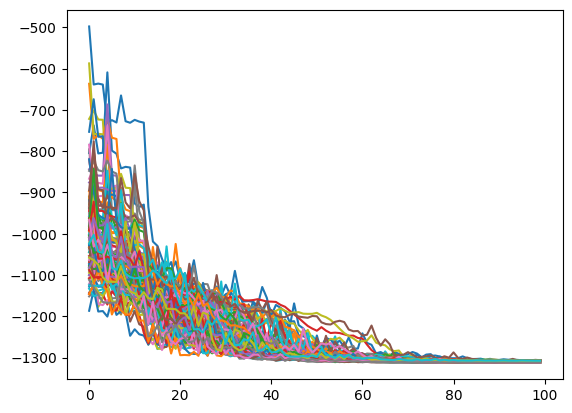

In [106]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    optimizer = COBYLA(maxiter=100, rhobeg=0.5)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

18.45434045791626
13.451246500015259
15.001257998943329
-1306.395424607962
-1311.9862792027159
-1309.161585864581


35

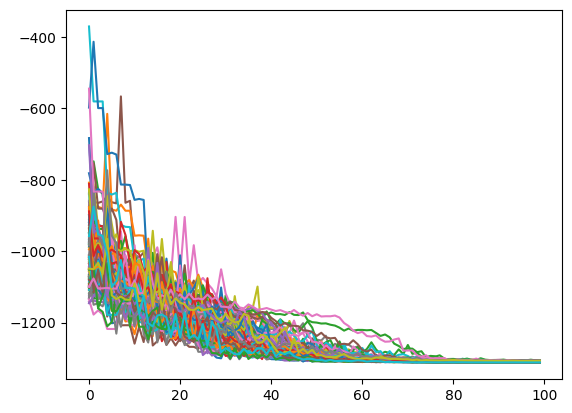

In [107]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=0.8)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

18.58490824699402
13.499794006347656
14.838906881809235
-1298.5865167430618
-1311.7897971336065
-1307.1512945446611


34

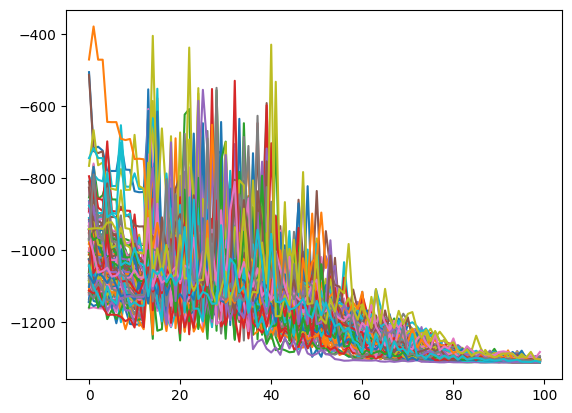

In [108]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=10)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

17.435810804367065
13.628514051437378
14.72876659154892
-1264.9776086001843
-1311.5812081133404
-1305.861379574075


38

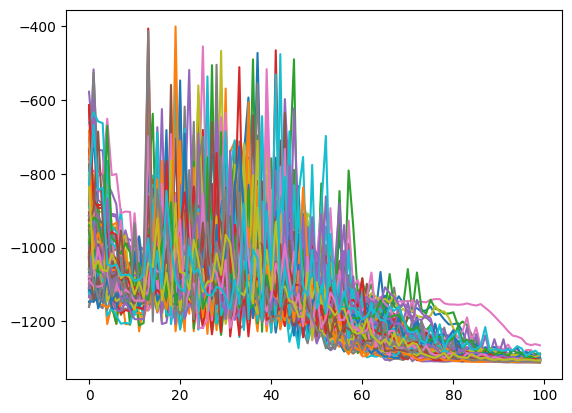

In [109]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=20)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

17.72514319419861
13.459037780761719
14.523950235843659
-1297.6534286750802
-1311.7154923990524
-1306.1647358214066


38

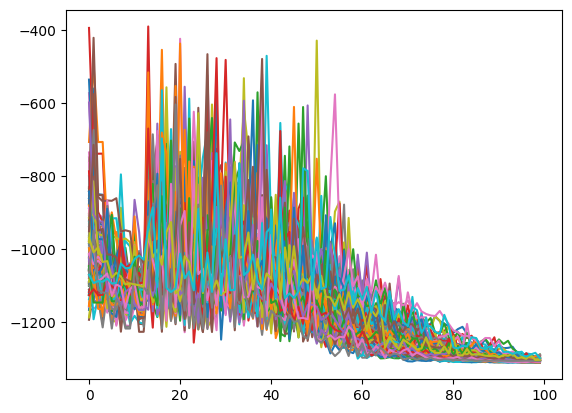

In [110]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=30)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

17.835535764694214
13.853325605392456
14.728670389965327
-1284.60053480196
-1310.5312093856408
-1303.6924548227385


23

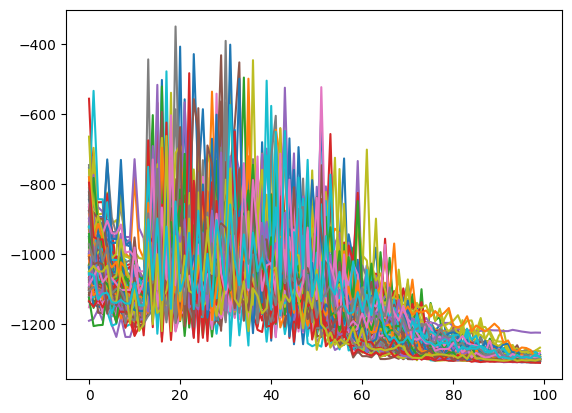

In [111]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=40)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

34.94773721694946
13.621138095855713
22.72044387578964
-1224.4387291138921
-1310.5331417048517
-1297.8392234379478


36

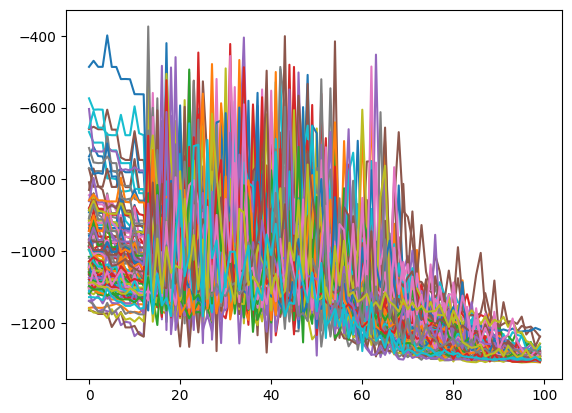

In [112]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=50)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

43.50936460494995
31.24052357673645
37.15500132083893
-1222.9918572567456
-1310.3911252141047
-1296.8583437735156


38

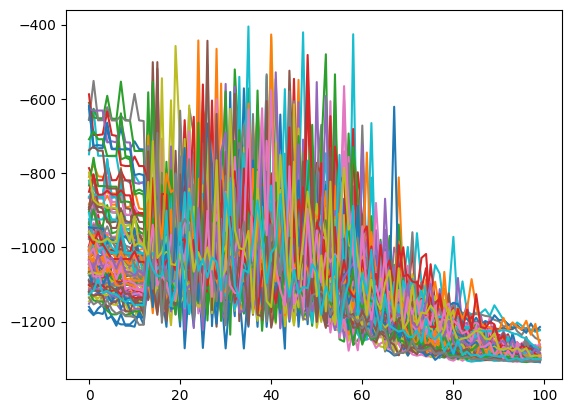

In [113]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=60)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

38.95734786987305
30.081080436706543
33.63412672042847
-1251.5099179878969
-1311.1025759943795
-1300.7503453984673


31

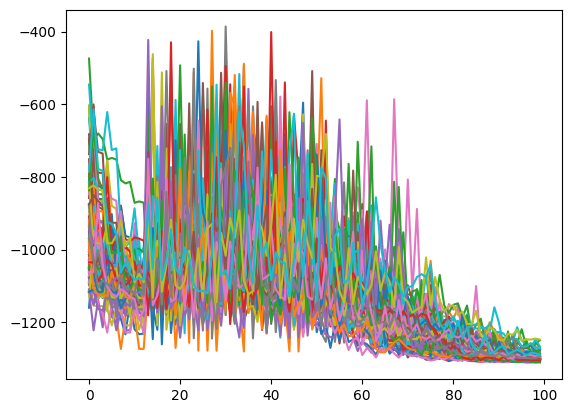

In [114]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=70)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

35.79181218147278
30.2088782787323
32.883449344924
-1236.521776258489
-1311.445564917507
-1299.4413050861494


35

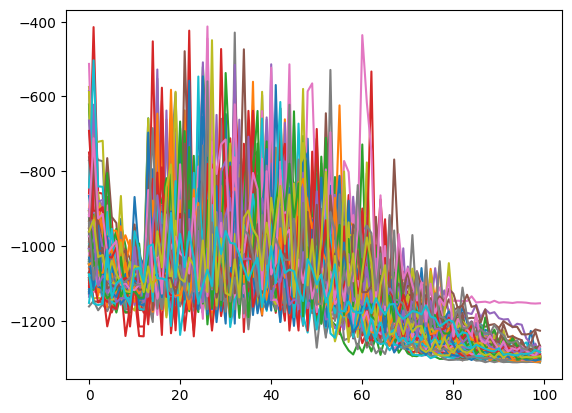

In [115]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=80)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

39.622089862823486
30.229366302490234
33.960503717865606
-1231.708047887716
-1309.2285202622736
-1296.164186111535


26

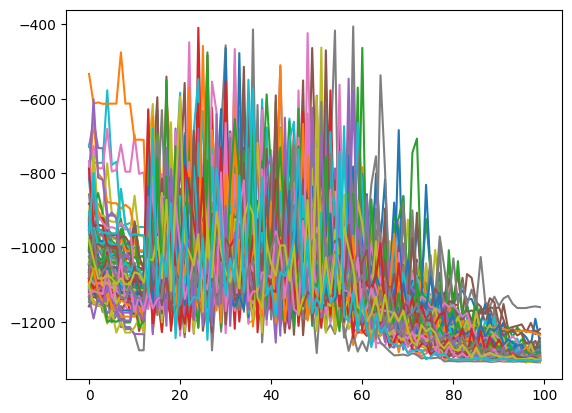

In [116]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=100)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

36.11879086494446
30.954442501068115
33.209362847805025
-1215.3703563257811
-1311.355330696505
-1294.7473394538795


28

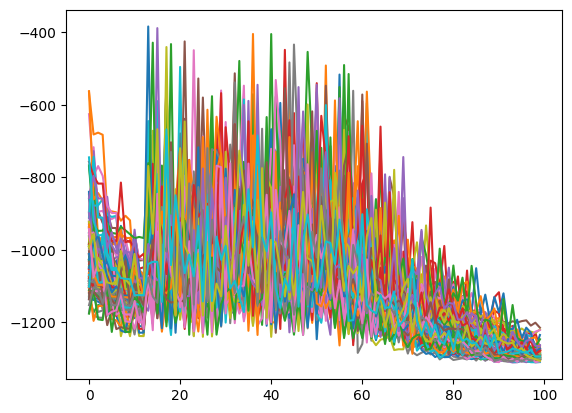

In [117]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=150)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

37.75887322425842
31.24442982673645
33.80901839034726
-1201.3422305493286
-1309.5301452191707
-1290.25339541926


35

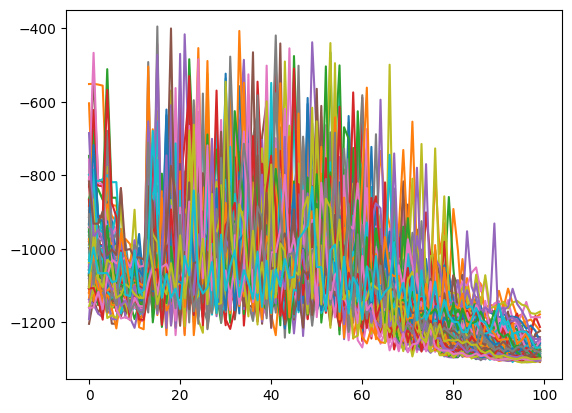

In [118]:
time=[]
energy=[]
solution=[]
for i in range (1,101,1):
    counts=[]
    params=[]
    values=[]
    mddict=[]
    #print(i)
    optimizer = COBYLA(maxiter=100, rhobeg=200)
    #ry_clb  = TwoLocal(qubitOp_tsp4.num_qubits, 'rx', "cz", reps=1, entanglement="linear")
    vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=qc2, optimizer=optimizer, callback=store_intermediate_result)
    # run SamplingVQE 
    result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4) 
    pylab.plot( values)
    #print("energy:", result_clb.eigenvalue.real)
    #print("time:", result_clb.optimizer_time)
    x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
    #print("feasible:", qp_tsp4.is_feasible(x_clb))
    if qp_tsp4.is_feasible(x_clb)== True:
        z_clb = tsp4.interpret(x_clb)
        #print("solution:", z_clb)
        #print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))
        energy.append(result_clb.eigenvalue.real)
        time.append(result_clb.optimizer_time)
        solution.append(tsp4.tsp_value(z_clb, adj_matrix1))
print(max(time))
print(min(time))
print(sum(time)/len(time))
print(max(energy))
print(min(energy))
print(sum(energy)/len(energy))
sum(1 for n in solution if n == 4)

In [ ]:
#Provare l'ansatz che sovrappone solo feasible solution--> TO DO.....